![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

## Colab Setup

In [ ]:
import json, os
import sys

if 'google.colab' in sys.modules:
    from google.colab import files

    if 'spark_ocr.json' not in os.listdir():
      license_keys = files.upload()
      os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
!pip install transformers
!pip install ipython-autotime

# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
#! pip uninstall spark-ocr -Y
%pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

## Initialize Spark Session

In [ ]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
import pkg_resources

from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

In [ ]:
# Start spark
spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)

Spark version: 3.2.1
Spark NLP version: 5.3.1
Spark OCR version: 5.3.1



## Read images and display it


    Image #0:
    Origin: file:/content/test_chart.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3307 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


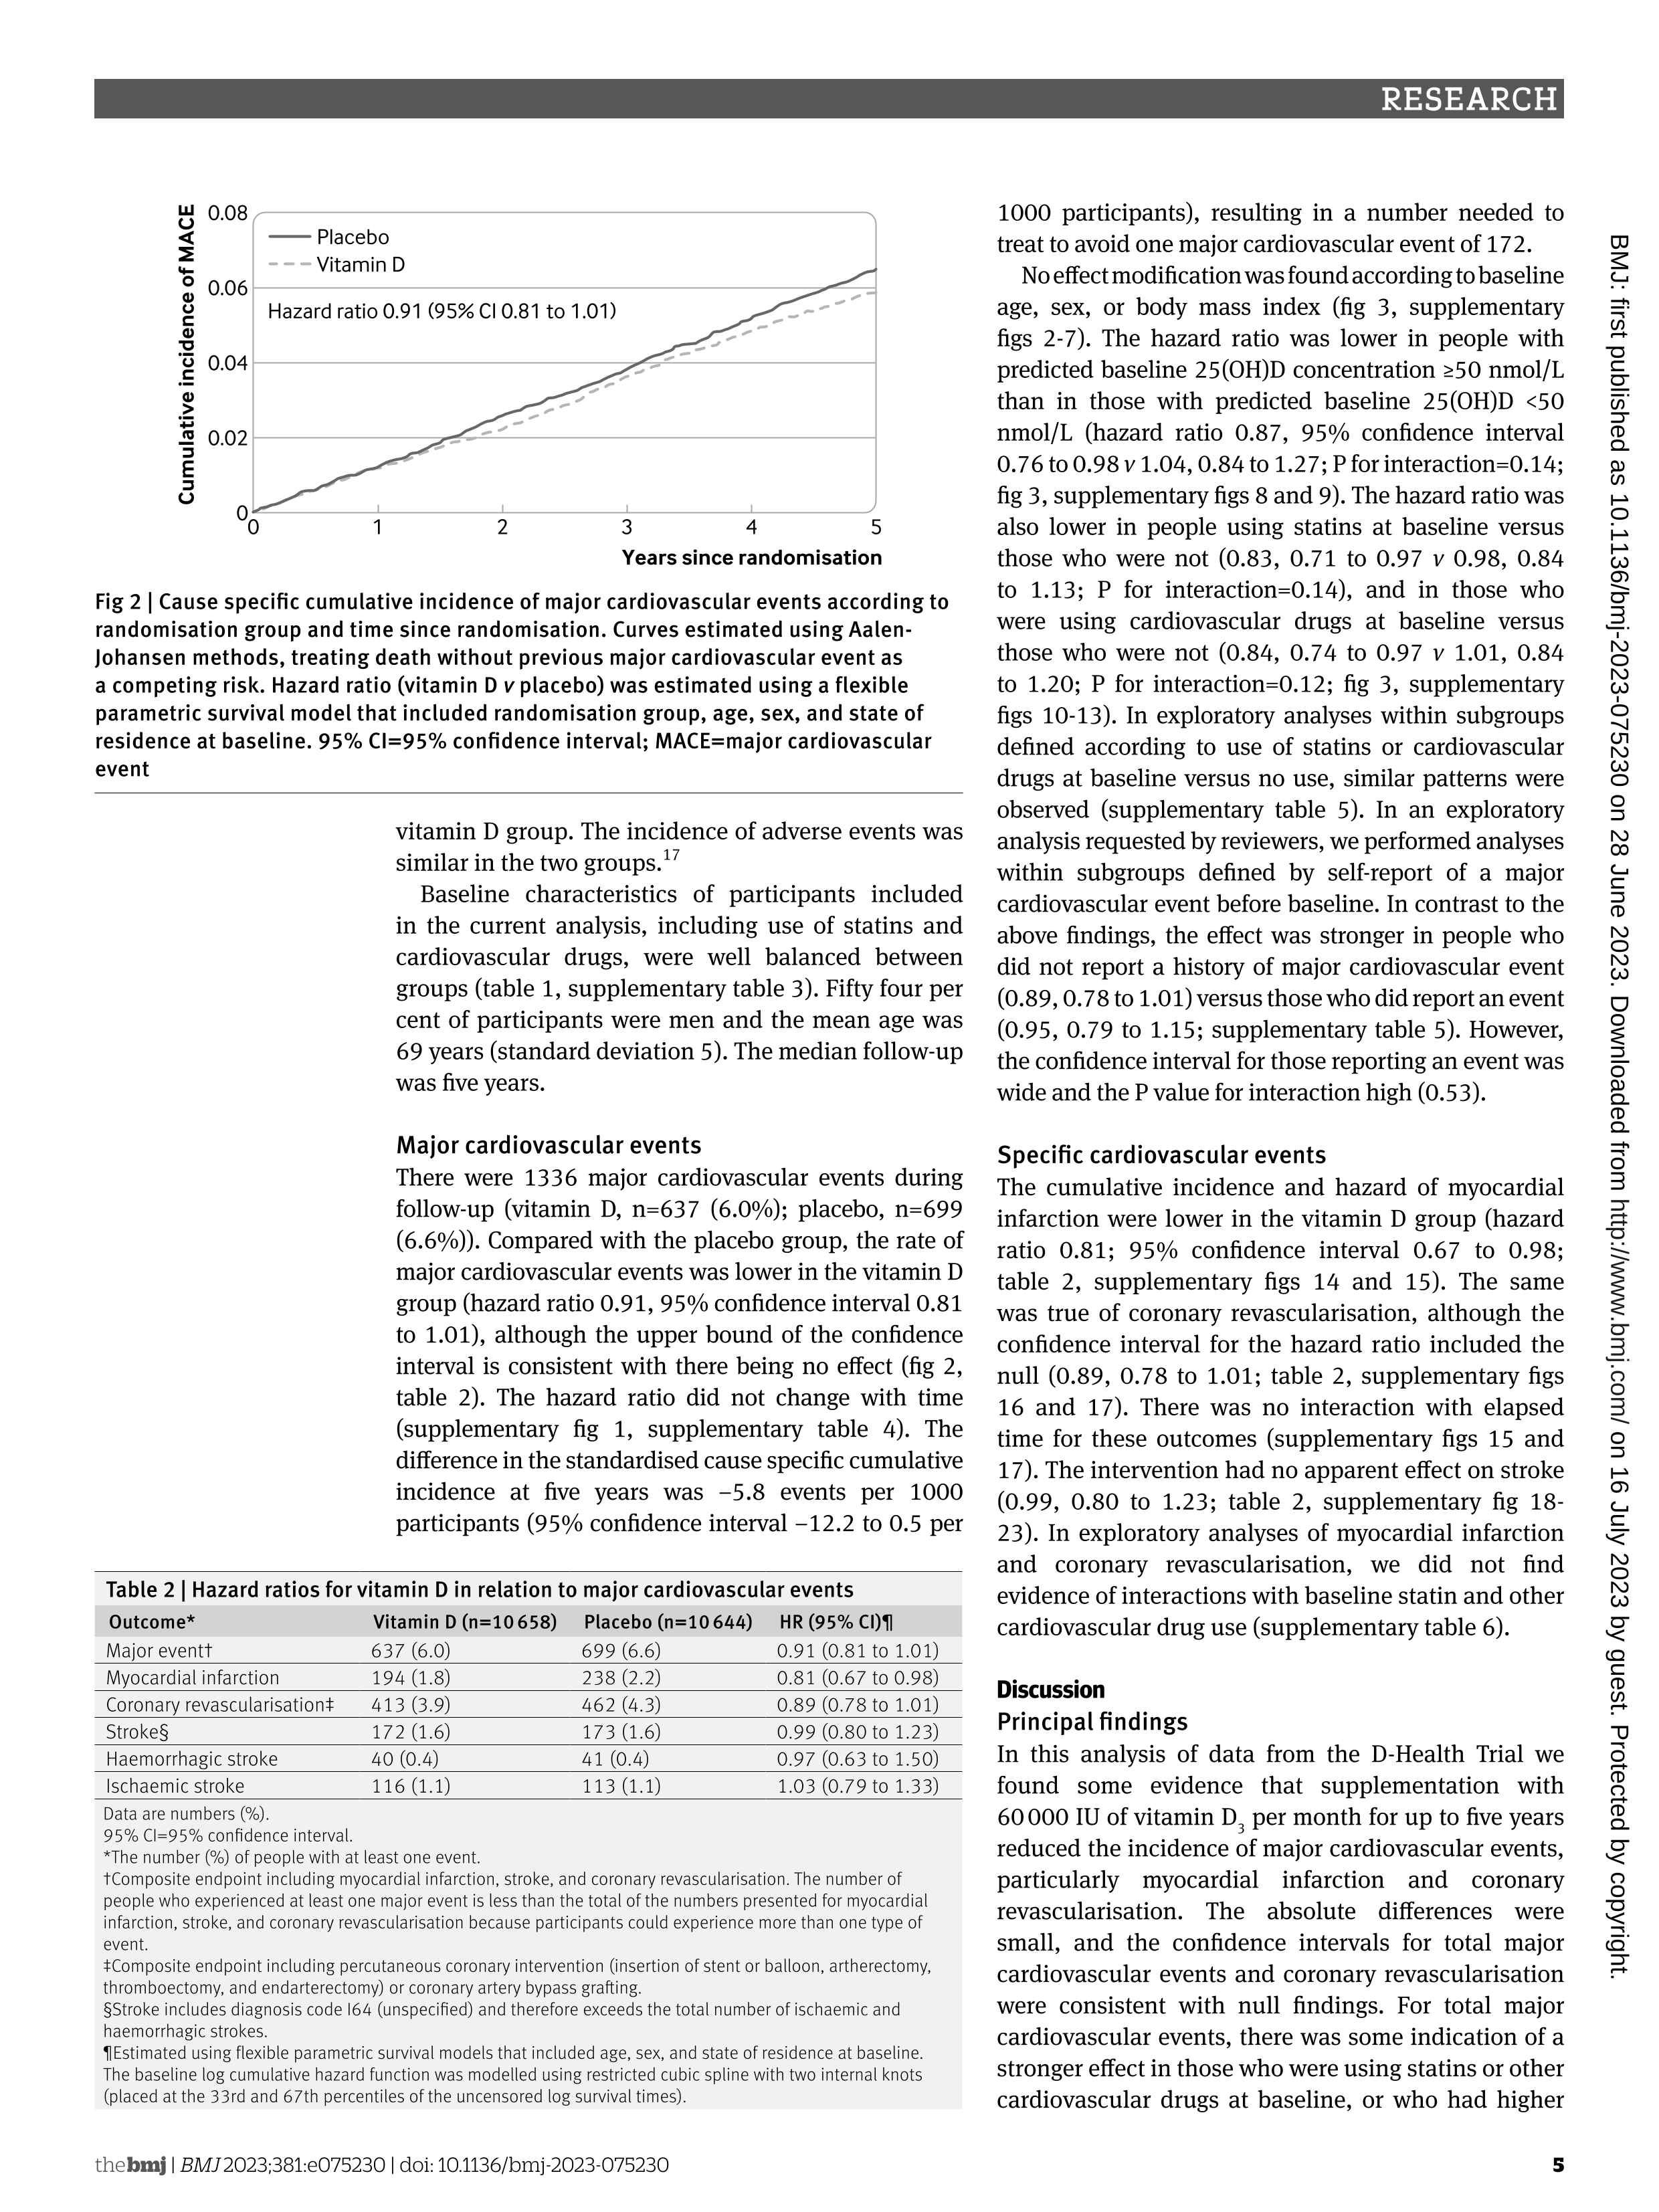

In [ ]:
pdf_path = "./pdfs/test_chart.pdf"
pdf_example_df = spark.read.format("binaryFile").load(pdf_path).cache()
display_pdf(pdf_example_df)

## Load Pipeline


In [ ]:
pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setKeepInput(True)

dit_layout = DocumentLayoutAnalyzer \
    .pretrained("publaynet_dit_base_mrcnn_jsl", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("regions") \
    .setScoreThreshold(0.6) \
    .setOutputLabels(["figure"])

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green)

splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("regions") \
    .setOutputCol("figure_image") \
    .setDropCols("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

chart_to_text = ChartToTextTable() \
    .pretrained("chart_to_text_deplot_jsl", "en", "clinical/ocr") \
    .setInputCol(["figure_image"]) \
    .setOutputCol("answers") \
    .setUseCaching(False)

pipeline = PipelineModel(stages=[
    pdf_to_image,
    dit_layout,
    draw_regions,
    splitter,
    chart_to_text
])

publaynet_dit_base_mrcnn_jsl download started this may take some time.
Approximate size to download 401.2 MB
chart_to_text_deplot_jsl download started this may take some time.
Approximate size to download 999.7 MB


## Call the pipeline

In [ ]:
result = pipeline.transform(pdf_example_df).cache()


    Image #0:
    Origin: file:/content/test_chart.pdf
    Resolution: 0 dpi
    Width: 2480 px
    Height: 3307 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


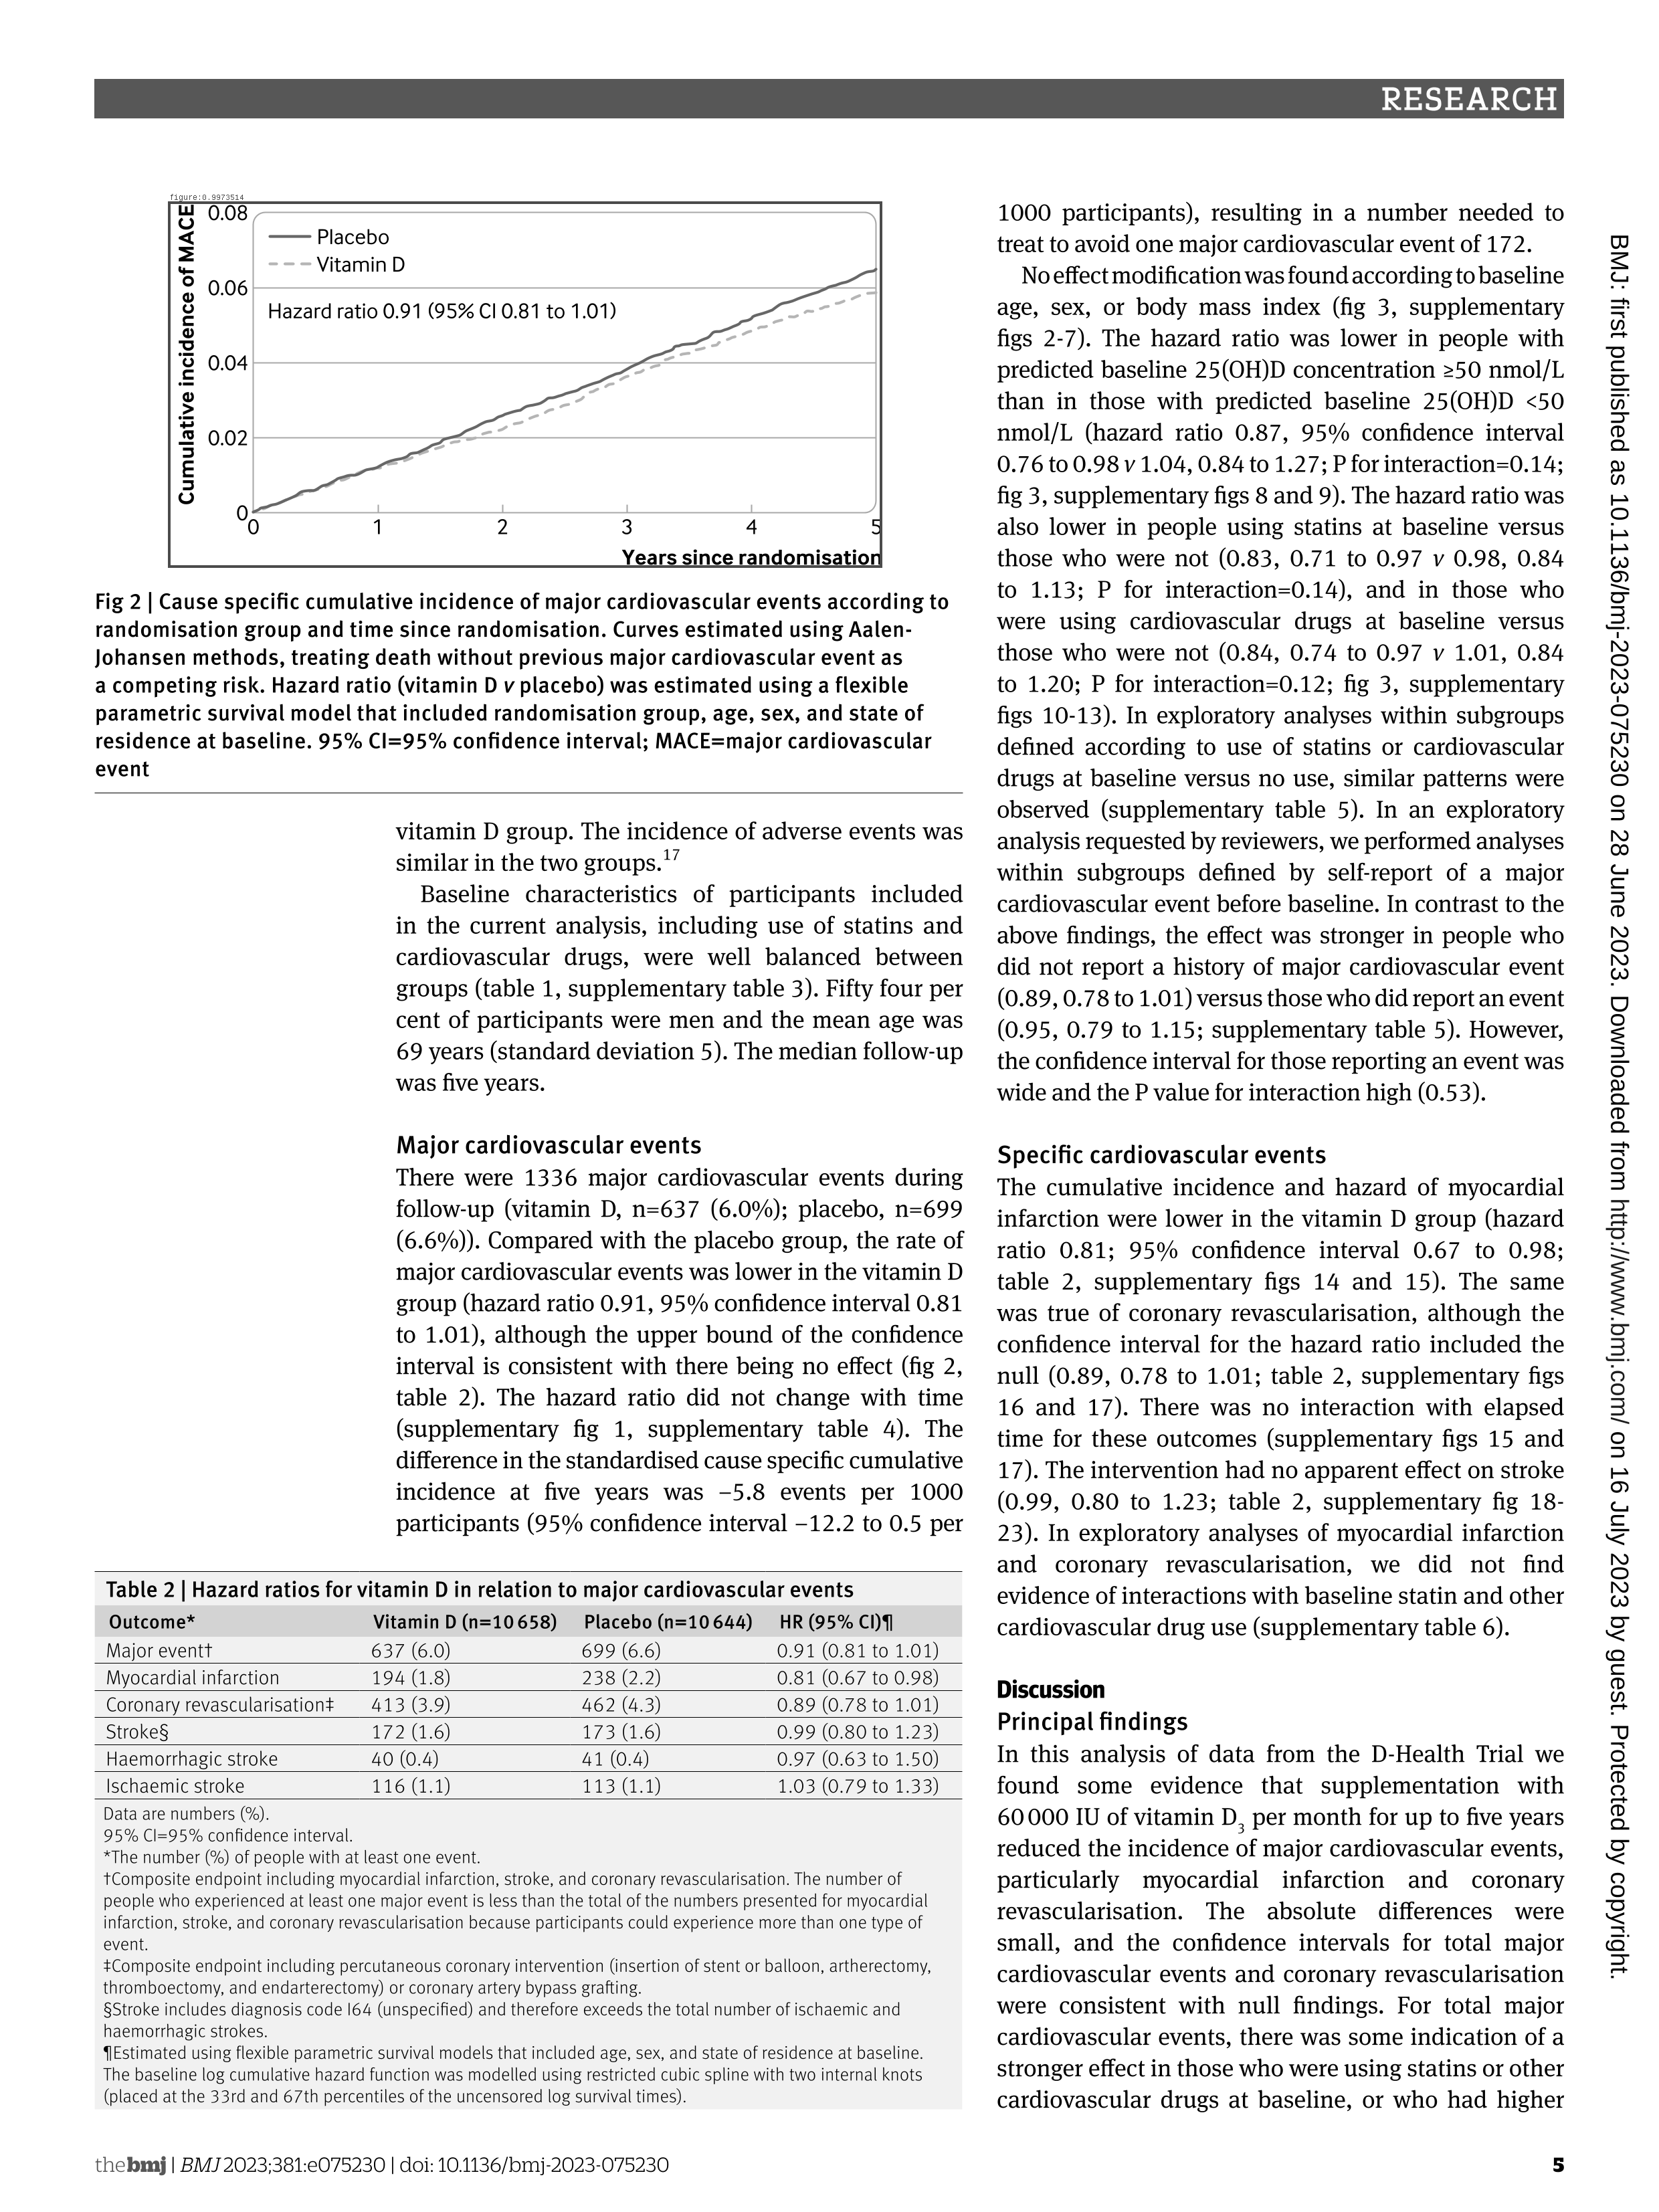

In [ ]:
display_images(result, "image_with_regions")


    Image #0:
    Origin: file:/content/test_chart.pdf
    Resolution: 0 dpi
    Width: 1064 px
    Height: 544 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


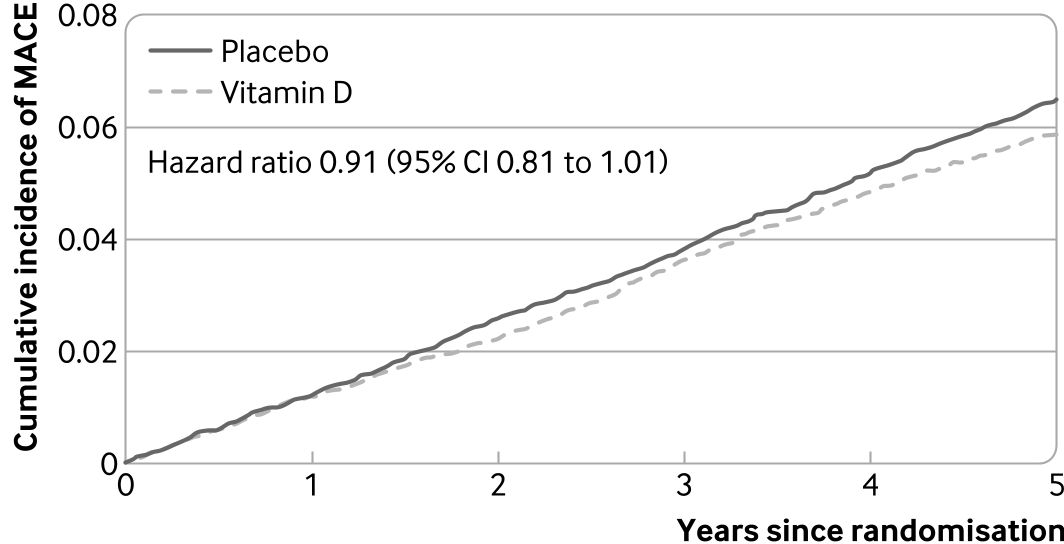

In [ ]:
display_images(result, "figure_image")

In [ ]:
result = result.select(result.answers.answers).first()[0]

In [ ]:
chart = result[0]
chart

'  TITLE |  <0x0A> Years since randomisation | Placebo | Vitamin D<0x0A>2000 | 0.00 | 0.01<0x0A>2005 | 0.00 | 0.02<0x0A>2010 | 0.00 | 0.02<0x0A>2015 | 0.00 | 0.04<0x0A>2017 | 0.00 | 0.02<0x0A>2018 | 0.00 | 0.03<0x0A>2019 | 0.00 | 0.04<0x0A>2020 | 0.00 | 0.02<0x0A>2021 | 0.00 | 0.02<0x0A>2022 | 0.03 | 0.02<0x0A>2023 | 0.04 | 0'

## LLM part: explaining the Deplot chart results using LLAMA2-7B

In [ ]:
# GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
#!pip install numpy==1.23.4

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama

model_name_or_path = "TheBloke/Llama-2-7B-chat-GGML"
model_basename = "llama-2-7b-chat.ggmlv3.q5_1.bin"

model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

In [ ]:
# GPU params set
lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,
    n_batch=3000,
    n_gpu_layers=32
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [ ]:
# See the number of layers in GPU
lcpp_llm.params.n_gpu_layers

32

In [ ]:
# Conversation template
prompt_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

USER: you are an expert in explaining charts. Can you please interpret as much as you can, the following information regarding a chart? "{chart}" (give me an answer please, this is not a conversation)

ASSISTANT:
'''

# Print the conversation template
print(prompt_template)


SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

USER: you are an expert in explaining charts. Can you please interpret as much as you can, the following information regarding a chart? "  TITLE |  <0x0A> Years since randomisation | Placebo | Vitamin D<0x0A>2000 | 0.00 | 0.01<0x0A>2005 | 0.00 | 0.02<0x0A>2010 | 0.00 | 0.02<0x0A>2015 | 0.00 | 0.04<0x0A>2017 | 0.00 | 0.02<0x0A>2018 | 0.00 | 0.03<0x0A>2019 | 0.00 | 0.04<0x0A>2020 | 0.00 | 0.02<0x0A>2021 | 0.00 | 0.02<0x0A>2022 | 0.03 | 0.02<0x0A>2023 | 0.04 | 0" (give me an answer please, this is not a conversation)

ASSISTANT:



In [ ]:
response=lcpp_llm(prompt=prompt_template, max_tokens=256, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)

In [ ]:
print(response)

{'id': 'cmpl-dfdc745d-863f-4da9-befb-8cd0043e53c8', 'object': 'text_completion', 'created': 1713195573, 'model': '/root/.cache/huggingface/hub/models--TheBloke--Llama-2-7B-chat-GGML/snapshots/76cd63c351ae389e1d4b91cab2cf470aab11864b/llama-2-7b-chat.ggmlv3.q5_1.bin', 'choices': [{'text': 'SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.\n\nUSER: you are an expert in explaining charts. Can you please interpret as much as you can, the following information regarding a chart? "  TITLE |  <0x0A> Years since randomisation | Placebo | Vitamin D<0x0A>2000 | 0.00 | 0.01<0x0A>2005 | 0.00 | 0.02<0x0A>2010 | 0.00 | 0.02<0x0A>2015 | 0.00 | 0.04<0x0A>2017 | 0.00 | 0.02<0x0A>2018 | 0.00 | 0.03<0x0A>2019 | 0.00 | 0.04<0x0A>2020 | 0.00 | 0.02<0x0A>2021 | 0.00 | 0.02<0x0A>2022 | 0.03 | 0.02<0x0A>2023 | 0.04 | 0" (give me an answer please, this is not a conversation)\n\nASSISTANT:\nThe chart shows the number of years since randomization for patients in each group (

## LLAMA2 interpretation results

In [ ]:
output = response["choices"][0]["text"].split("ASSISTANT:")[1]
print (output)


The chart shows the number of years since randomization for patients in each group (Placebo and Vitamin D). The x-axis represents the time since randomization, ranging from 2000 to 2023. The y-axis represents the proportion of patients in each group who have achieved a given level of vitamin D concentration, with 0 representing no change and 1 representing maximum improvement.

The chart shows that:

* In general, there is no significant difference in the rate of vitamin D increase between the Placebo and Vitamin D groups over time (as evidenced by the near-overlapping of the blue and red lines).
* The Vitamin D group has a slightly higher proportion of patients with high levels of vitamin D concentration (0.04) compared to the Placebo


In [ ]:
import textwrap
output = textwrap.fill(output, width=100)
print(output)

 The chart shows the number of years since randomization for patients in each group (Placebo and
Vitamin D). The x-axis represents the time since randomization, ranging from 2000 to 2023. The
y-axis represents the proportion of patients in each group who have achieved a given level of
vitamin D concentration, with 0 representing no change and 1 representing maximum improvement.  The
chart shows that:  * In general, there is no significant difference in the rate of vitamin D
increase between the Placebo and Vitamin D groups over time (as evidenced by the near-overlapping of
the blue and red lines). * The Vitamin D group has a slightly higher proportion of patients with
high levels of vitamin D concentration (0.04) compared to the Placebo
